In [1]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from copy import copy

from synthetic_data import load_data_by_gtype, add_p_and_delta
from ic import make_partial_cascade
from core import normalize_mu
from edge_mwu import median_node

In [42]:
gtype = 'grid'
g = load_data_by_gtype(gtype, '2-4')[0]
g = add_p_and_delta(g, 0.8, 1)

In [3]:
def noisy_binary_search(g, 
                        source, 
                        infection_times,
                        obs_nodes,
                        sp_len, 
                        consistency_multiplier,
                        max_iter,
                        uninfected_simulation_rounds=100,
                        debug=False,
                        save_log=False):
    # observed from the plot in infection_probability_vs_fraction_of_shortest_path.ipynb
    mu = {n: 1 for n in g.nodes_iter()}
    for n in obs_nodes:
        mu[n] = 0

    queried_nodes = copy(obs_nodes)
    querie_nodes_log = []
    for i in range(max_iter):
        if debug:
            print('source\'s mu: {:.2f}'.format(mu[source]))
        
        if len(queried_nodes) == g.number_of_nodes():
            break
        q = median_node(g, mu, sp_len)
        queried_nodes.add(q)

        if save_log:
            querie_nodes_log.append(q)
        if debug:
            print('query node: {}'.format(q))

        if np.isinf(infection_times[q]):
            if debug:
                print('query is not infected')
            # estimate the fraction of simulations that n is not infected
            reward = {n: 0 for n in g.nodes_iter()}
            for i in range(uninfected_simulation_rounds):
                sg = sample_graph_from_infection(g)
                sp_len_prime = nx.shortest_path_length(sg, source=q)
                for n in g.nodes_iter():
                    if n not in sp_len_prime:
                        reward[n] += 1
            for n in g.nodes_iter():
                mu[n] *= (reward[n] / uninfected_simulation_rounds)
                
            mu = normalize_mu(mu)
        else:
            # check if q is source
            found_source = True            
            for n in g.neighbors_iter(q):
                if infection_times[q] > infection_times[n]:
                    found_source = False

            if found_source:
                assert q == source, '{} != {} ({} and {})'.format(
                    q, source,
                    infection_times[q],
                    infection_times[source])
                break            

            possible_ancestors = []                
            if False:                
                for n in g.neighbors_iter(q):        
                    queried_nodes.add(n)
                    if save_log:
                        querie_nodes_log.append(n)
                    if infection_times[q] - infection_times[n] == g[n][q]['d']:
                        possible_ancestors.append(n)
            else:
                # using just one ancestor node
                for n in g.neighbors_iter(q):        
                    queried_nodes.add(n)
                    if save_log:
                        querie_nodes_log.append(n)
                    if infection_times[q] - infection_times[n] == g[n][q]['d']:
                        possible_ancestors.append(n)
                        break
                
            if debug:
                print('ancestor nodes: {}'.format(possible_ancestors))

            if len(possible_ancestors) > 0:
                for a in possible_ancestors:
                    for n in g.nodes_iter():
                        if sp_len[n][q] == (sp_len[n][a] + g[a][q]['d']):
                            mu[n] *= consistency_multiplier
                        else:
                            mu[n] *= (1 - consistency_multiplier)
                    mu = normalize_mu(mu)

        query_count = len(queried_nodes - obs_nodes)
    if debug:
        print('used {} queries to find the source'.format(query_count))
    if save_log:
        return query_count, queried_nodes
    else:
        return query_count          

In [4]:
def one_round(g, sp_len,
              consistency_multiplier,
              debug=False):
    source, obs_nodes, infection_times, _ = make_partial_cascade(g, 0.01)

    c = noisy_binary_search(g, source, infection_times,
                            obs_nodes,
                            sp_len, 
                            consistency_multiplier=consistency_multiplier,
                            max_iter=g.number_of_nodes(),
                            debug=debug)
    return c
    
def experiment_n_rounds(g, N,
                        consistency_multiplier):
    sp_len = nx.shortest_path_length(g)
    cnts = []
    return Parallel(n_jobs=-1)(delayed(one_round)(g, sp_len, consistency_multiplier)
                               for i in tqdm(range(N)))


In [43]:
# relationship between consistency_multiplier and query_count
multipliers = [0.6, 0.7, 0.8, 0.9]
means = []
medians = []
for mtp in multipliers:
    print(mtp)
    cnts = experiment_n_rounds(g, 100, mtp)
    s = pd.Series(cnts).describe()
    means.append(s['mean'])
    medians.append(s['50%'])    

  0%|          | 0/100 [00:00<?, ?it/s]

0.6


  0%|          | 0/100 [00:00<?, ?it/s]

0.7


  0%|          | 0/100 [00:00<?, ?it/s]

0.8


  0%|          | 0/100 [00:00<?, ?it/s]

0.9


100%|██████████| 100/100 [00:09<00:00, 10.13it/s]


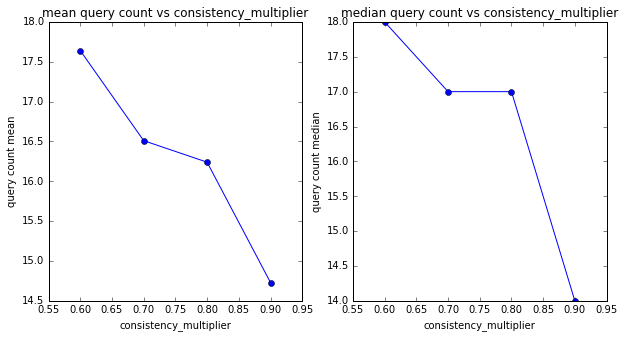

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(multipliers, means, 'o-')
ax[0].set_title('mean query count vs consistency_multiplier')
ax[0].set_xlabel('consistency_multiplier')
ax[0].set_ylabel('query count mean')

ax[1].plot(multipliers, medians, 'o-')
ax[1].set_title('median query count vs consistency_multiplier')
ax[1].set_xlabel('consistency_multiplier')
ax[1].set_ylabel('query count median')
fig.savefig('figs/noisy_binary_search_consistency_multiplier/{}.png'.format(gtype))